In [2]:
# Common
import os
import keras
import numpy as np
from tqdm import tqdm
import cv2 as cv
from glob import glob
import tensorflow as tf

# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras import Sequential
from keras.layers import Conv2D, Conv2DTranspose, InputLayer, Layer, Input, Dropout, MaxPool2D, concatenate
from keras.optimizers import Adam
import cv2
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
images,masks=[],[]

for i in range(3000):
    image_path=os.path.join('Dataset\Images',os.listdir('Dataset\Images')[i])
    masks_path=os.path.join('Dataset\Masks',os.listdir('Dataset\Masks')[i])
    
    img=cv2.imread(image_path)
    mask=cv2.imread(masks_path)

    img=img/255
    mask=mask/255

    img = cv2.GaussianBlur(img, (1, 1), 0)
    mask = cv2.GaussianBlur(mask, (1, 1), 0)

    images.append(img)
    masks.append(mask)

images=np.array(images)
masks=np.array(masks)

In [7]:
X_train, y_train = images[:2000], masks[:2000]
X_valid, y_valid = images[2000:], masks[2000:]

In [8]:
class EncoderLayerBlock(Layer):
    def __init__(self, filters, rate, pooling=True):
        super(EncoderLayerBlock, self).__init__()
        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(self.filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(self.rate)
        self.c2 = Conv2D(self.filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D(pool_size=(2,2))

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else: 
            return x

    def get_config(self):
        base_estimator = super().get_config()
        return {
            **base_estimator,
            "filters":self.filters,
            "rate":self.rate,
            "pooling":self.pooling
        }

#  Decoder Layer
class DecoderLayerBlock(Layer):
    def __init__(self, filters, rate, padding='same'):
            super(DecoderLayerBlock, self).__init__()
            self.filters = filters
            self.rate = rate
            self.cT = Conv2DTranspose(self.filters, kernel_size=3, strides=2, padding=padding)
            self.next = EncoderLayerBlock(self.filters, self.rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.cT(X)
        c1 = concatenate([x, skip_X])
        y = self.next(c1)
        return y 

    def get_config(self):
        base_estimator = super().get_config()
        return {
            **base_estimator,
            "filters":self.filters,
            "rate":self.rate,
        }

#  Callback 
class ShowProgress(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        id = np.random.randint(len(X_valid))
        rand_img = X_valid[id][np.newaxis,...]
        pred_mask = self.model.predict(rand_img)[0]
        true_mask = y_valid[id]


        plt.subplot(1,3,1)
        plt.imshow(rand_img[0])
        plt.title("Original Image")
        plt.axis('off')


        plt.subplot(1,3,2)
        plt.imshow(pred_mask)
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(true_mask)
        plt.title("True Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
checkpoint_path = 'weight'
ckpt_callback = ModelCheckpoint(filepath=os.path.join('weight', 'weights.{epoch:02d}.{accuracy:.4f}.hdf5'), monitor = 'val_mean_io_u', save_best_only=True)

In [ ]:
def checkpoint_function():
    # if there is no file being saved in the checkpoint path then routine will go to loop model.fit(X, y, epochs=150, batch_size=1, callbacks=[ckpt_callback])
    # this signifies that no file is saved in the checkpoint path and let us begin the training from the first epoch.
    if not os.listdir(checkpoint_path):
        return
    # this loop will fetch epochs number in a list    
    files_int = list()
    for i in os.listdir(checkpoint_path):
        epoch = int(i.split('.')[1])
        files_int.append(epoch)
    # getting the maximum value for an epoch from the list
    # this is reference value and will help to find the file with that value    
    max_value = max(files_int)
    # conditions are applied to find the file which has the maximum value of epoch
    # such file would be the last file where the training is stopped and we would like to resume the training from that point.
    for i in os.listdir(checkpoint_path):
        epoch = int(i.split('.')[1])
        if epoch > max_value:
            pass
        elif epoch < max_value:
            pass
        else:
            final_file = i    
    # in the end we will get the epoch as well as file         
    return final_file, max_value   

In [ ]:
checkpoint_path_file = checkpoint_function()
print(checkpoint_path_file)
print(checkpoint_path)

Epoch 1/50
1/1 [==============================] - 1s 833ms/steps: 0.7040 - accuracy: 0.3917 - mean_io_u: 0.499


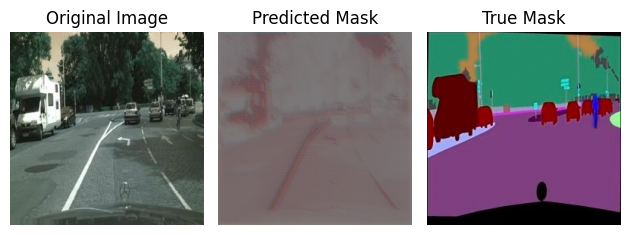

7/7 [==============================] - 175s 25s/step - loss: 0.7040 - accuracy: 0.3917 - mean_io_u: 0.4999 - val_loss: 0.6642 - val_accuracy: 0.4365 - val_mean_io_u: 0.4999
Epoch 2/50
1/1 [==============================] - 0s 178ms/steps: 0.6630 - accuracy: 0.3799 - mean_io_u: 0.499


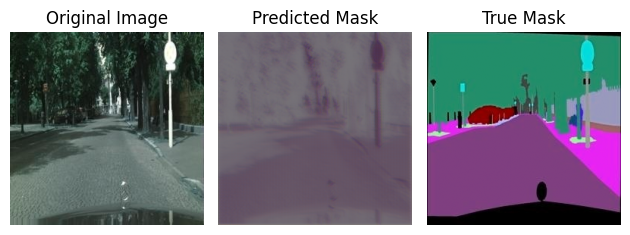

7/7 [==============================] - 186s 27s/step - loss: 0.6630 - accuracy: 0.3799 - mean_io_u: 0.4999 - val_loss: 0.6507 - val_accuracy: 0.4082 - val_mean_io_u: 0.4999
Epoch 3/50
1/1 [==============================] - 0s 233ms/steps: 0.6540 - accuracy: 0.4097 - mean_io_u: 0.499


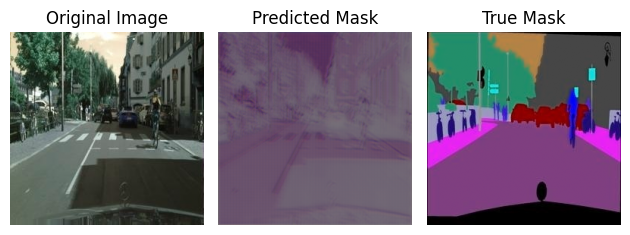

7/7 [==============================] - 158s 23s/step - loss: 0.6540 - accuracy: 0.4097 - mean_io_u: 0.4999 - val_loss: 0.6460 - val_accuracy: 0.4037 - val_mean_io_u: 0.4999
Epoch 4/50
7/7 [==============================] - ETA: 0s - loss: 0.6487 - accuracy: 0.4157 - mean_io_u: 0.4999 

In [9]:
# Input Layer 
input_layer = Input(shape=X_train.shape[-3:])

# Encoder
p1, c1 = EncoderLayerBlock(16,0.1)(input_layer)
p2, c2 = EncoderLayerBlock(32,0.1)(p1)
p3, c3 = EncoderLayerBlock(64,0.2)(p2)
p4, c4 = EncoderLayerBlock(128,0.2)(p3)

# Encoding Layer
c5 = EncoderLayerBlock(256,0.3,pooling=False)(p4)

# Decoder
d1 = DecoderLayerBlock(128,0.2)([c5, c4])
d2 = DecoderLayerBlock(64,0.2)([d1, c3])
d3 = DecoderLayerBlock(32,0.2)([d2, c2])
d4 = DecoderLayerBlock(16,0.2)([d3, c1])

# Output layer
output = Conv2D(3,kernel_size=1,strides=1,padding='same',activation='sigmoid')(d4)

# U-Net Model
model = keras.models.Model(
    inputs=[input_layer],
    outputs=[output],
)

# Compiling
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', keras.metrics.MeanIoU(num_classes=2)]
)

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
from keras.models import load_model
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
with tf.device('/GPU:1'):
    # Train The Model
    # model.fit(
    #     X_train, y_train,
    #     validation_data=(X_valid, y_valid),
    #     epochs=2000,
    #     callbacks=callbacks
    # )

    if checkpoint_path_file is not None:
        # Load model:
        checkpoint_path_file = checkpoint_function()[0]
        max_value = checkpoint_function()[1]

        model = load_model(os.path.join(checkpoint_path, checkpoint_path_file))
        model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=150, batch_size=1, callbacks=[ckpt_callback,ShowProgress()], initial_epoch = max_value)  
        # print("Training completed")  
    # if there is no checkpoint_path_file it means no file is saved and hence model will be trained from scratch
    # file is saved in form of .hdf5 extension 
    else:
        model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=150, batch_size=1, callbacks=[ckpt_callback,ShowProgress()])
